Кемерова А.М. ИУ5-61Б

# Лабораторная работа №5. Линейные модели, SVM и деревья решений

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, recall_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

%matplotlib inline 
sns.set(style="ticks")

In [2]:
filepath = "datasets/Corruption_Perception_Index.csv"

data = pd.read_csv(filepath, sep=',')
data

,2016 Rank,Country,2016 Score,2015 Score,2014 Score,2013 Score,2012 Score,Region
0,1,Denmark,90,91.0,92.0,91.0,90.0,Europe and Central Asia
1,1,New Zealand,90,88.0,91.0,91.0,90.0,Asia Pacific
2,3,Finland,89,90.0,89.0,89.0,90.0,Europe and Central Asia
3,4,Sweden,88,89.0,87.0,89.0,88.0,Europe and Central Asia
4,5,Switzerland,86,86.0,86.0,85.0,86.0,Europe and Central Asia
...,...,...,...,...,...,...,...,...
171,170,Yemen,14,18.0,19.0,18.0,23.0,Middle East and North Africa
172,173,Syria,13,18.0,20.0,17.0,26.0,Middle East and North Africa
173,174,Korea (North),12,8.0,8.0,8.0,8.0,Asia Pacific
174,175,South Sudan,11,15.0,15.0,14.0,NaN,Sub Saharan Africa


In [3]:
data = data.drop('Country', axis=1, inplace=False)
data

,2016 Rank,2016 Score,2015 Score,2014 Score,2013 Score,2012 Score,Region
0,1,90,91.0,92.0,91.0,90.0,Europe and Central Asia
1,1,90,88.0,91.0,91.0,90.0,Asia Pacific
2,3,89,90.0,89.0,89.0,90.0,Europe and Central Asia
3,4,88,89.0,87.0,89.0,88.0,Europe and Central Asia
4,5,86,86.0,86.0,85.0,86.0,Europe and Central Asia
...,...,...,...,...,...,...,...
171,170,14,18.0,19.0,18.0,23.0,Middle East and North Africa
172,173,13,18.0,20.0,17.0,26.0,Middle East and North Africa
173,174,12,8.0,8.0,8.0,8.0,Asia Pacific
174,175,11,15.0,15.0,14.0,NaN,Sub Saharan Africa


In [4]:
data.isnull().sum()

2016 Rank     0
2016 Score    0
2015 Score    9
2014 Score    5
2013 Score    3
2012 Score    4
Region        0
dtype: int64

# Заполнение пропусков

In [5]:
strategies=['mean', 'median','most_frequent']

In [6]:
mean = SimpleImputer(strategy = strategies[0])
mean = mean.fit_transform(data[["2015 Score"]])
data["2015 Score"] = mean

In [7]:
median = SimpleImputer(strategy = strategies[1])
median = median.fit_transform(data[["2014 Score"]])
data["2014 Score"] = median

In [8]:
most_frequent = SimpleImputer(strategy = strategies[2])
most_frequent = most_frequent.fit_transform(data[["2013 Score"]])
data["2013 Score"] = most_frequent

most_frequent = SimpleImputer(strategy = strategies[2])
most_frequent = most_frequent.fit_transform(data[["2012 Score"]])
data["2012 Score"] = most_frequent

In [9]:
data.isnull().sum()

2016 Rank     0
2016 Score    0
2015 Score    0
2014 Score    0
2013 Score    0
2012 Score    0
Region        0
dtype: int64

# Кодирование категориального признака "Region"

In [10]:
le = LabelEncoder()
le = le.fit_transform(data['Region'])
data['Region'] = le
data

,2016 Rank,2016 Score,2015 Score,2014 Score,2013 Score,2012 Score,Region
0,1,90,91.0,92.0,91.0,90.0,2
1,1,90,88.0,91.0,91.0,90.0,1
2,3,89,90.0,89.0,89.0,90.0,2
3,4,88,89.0,87.0,89.0,88.0,2
4,5,86,86.0,86.0,85.0,86.0,2
...,...,...,...,...,...,...,...
171,170,14,18.0,19.0,18.0,23.0,3
172,173,13,18.0,20.0,17.0,26.0,3
173,174,12,8.0,8.0,8.0,8.0,1
174,175,11,15.0,15.0,14.0,34.0,4


In [11]:
data['Region'].value_counts()

2    50
4    44
0    32
1    30
3    20
Name: Region, dtype: int64

In [12]:
# Конвертация целевого признака в бинарный
def convert_target_to_binary(array:np.ndarray) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==2 or x==4 else 0 for x in array]
    return res

In [13]:
# Конвертация предсказанных признаков
data['Region'] = convert_target_to_binary(data['Region'])

In [14]:
# Убедимся, что целевой признак
# для задачи бинарной классификации содержит только 0 и 1
data['Region'].unique()

array([1, 0], dtype=int64)

In [15]:
data['Region'].value_counts()

1    94
0    82
Name: Region, dtype: int64

In [16]:
# посчитаем дисбаланс классов
total = data.shape[0]
class_1, class_0 = data['Region'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 2)*100, round(class_1 / total, 2)*100))

Класс 0 составляет 47.0%, а класс 1 составляет 53.0%.


Дисбаланса классов практически нет

In [17]:
# Разделим данные на целевой столбец и признаки
X = data.drop("Region", axis=1)
Y = data["Region"]
print(X, "\n")
print(Y)

     2016 Rank  2016 Score  2015 Score  2014 Score  2013 Score  2012 Score
0            1          90        91.0        92.0        91.0        90.0
1            1          90        88.0        91.0        91.0        90.0
2            3          89        90.0        89.0        89.0        90.0
3            4          88        89.0        87.0        89.0        88.0
4            5          86        86.0        86.0        85.0        86.0
..         ...         ...         ...         ...         ...         ...
171        170          14        18.0        19.0        18.0        23.0
172        173          13        18.0        20.0        17.0        26.0
173        174          12         8.0         8.0         8.0         8.0
174        175          11        15.0        15.0        14.0        34.0
175        176          10         8.0         8.0         8.0         8.0

[176 rows x 6 columns] 

0      1
1      0
2      1
3      1
4      1
      ..
171    0
172    0
17

In [18]:
# Предобработаем данные, чтобы методы работали лучше
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,2016 Rank,2016 Score,2015 Score,2014 Score,2013 Score,2012 Score
count,1.760000e+02,1.760000e+02,1.760000e+02,176.000000,1.760000e+02,176.000000
mean,-1.614870e-16,1.614870e-16,1.614870e-16,0.000000,1.614870e-16,0.000000
std,1.002853e+00,1.002853e+00,1.002853e+00,1.002853,1.002853e+00,1.002853
min,-1.710303e+00,-1.700023e+00,-1.763686e+00,-1.777454,-1.731490e+00,-1.796677
25%,-8.571243e-01,-7.197029e-01,-7.411707e-01,-0.705238,-7.244104e-01,-0.720592
50%,-3.945725e-03,-2.553406e-01,-2.299129e-01,-0.245716,-2.712248e-01,-0.310655
75%,8.690742e-01,7.249797e-01,5.369737e-01,0.583975,6.477351e-01,0.624513
max,1.761935e+00,2.427641e+00,2.479753e+00,2.511412,2.447889e+00,2.405178


# Разделение выборки на обучающую и тестовую

In [19]:
# С использованием метода train_test_split разделим выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_test:", Y_test.shape)

X_train: (132, 6)
X_test: (44, 6)
Y_train: (132,)
Y_test: (44,)


In [20]:
def test_model(model):
    print("f1_score:",
          f1_score(Y_test, model.predict(X_test)))
    print("recall_score:",
          recall_score(Y_test, model.predict(X_test)))  

# Линейная модель

In [21]:
SGD = SGDClassifier(max_iter = 10000)
SGD.fit(X_train, Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
test_model(SGD)

f1_score: 0.3913043478260869
recall_score: 0.4090909090909091


# Метод опорных векторов

In [23]:
SVC = SVC(kernel='rbf')
SVC.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
test_model(SVC)

f1_score: 0.6666666666666666
recall_score: 1.0


# Дерево решений

In [25]:
DTС = DecisionTreeClassifier(random_state=1)
DTС.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [26]:
test_model(DTС)

f1_score: 0.5714285714285713
recall_score: 0.5454545454545454


# Визуализация дерева

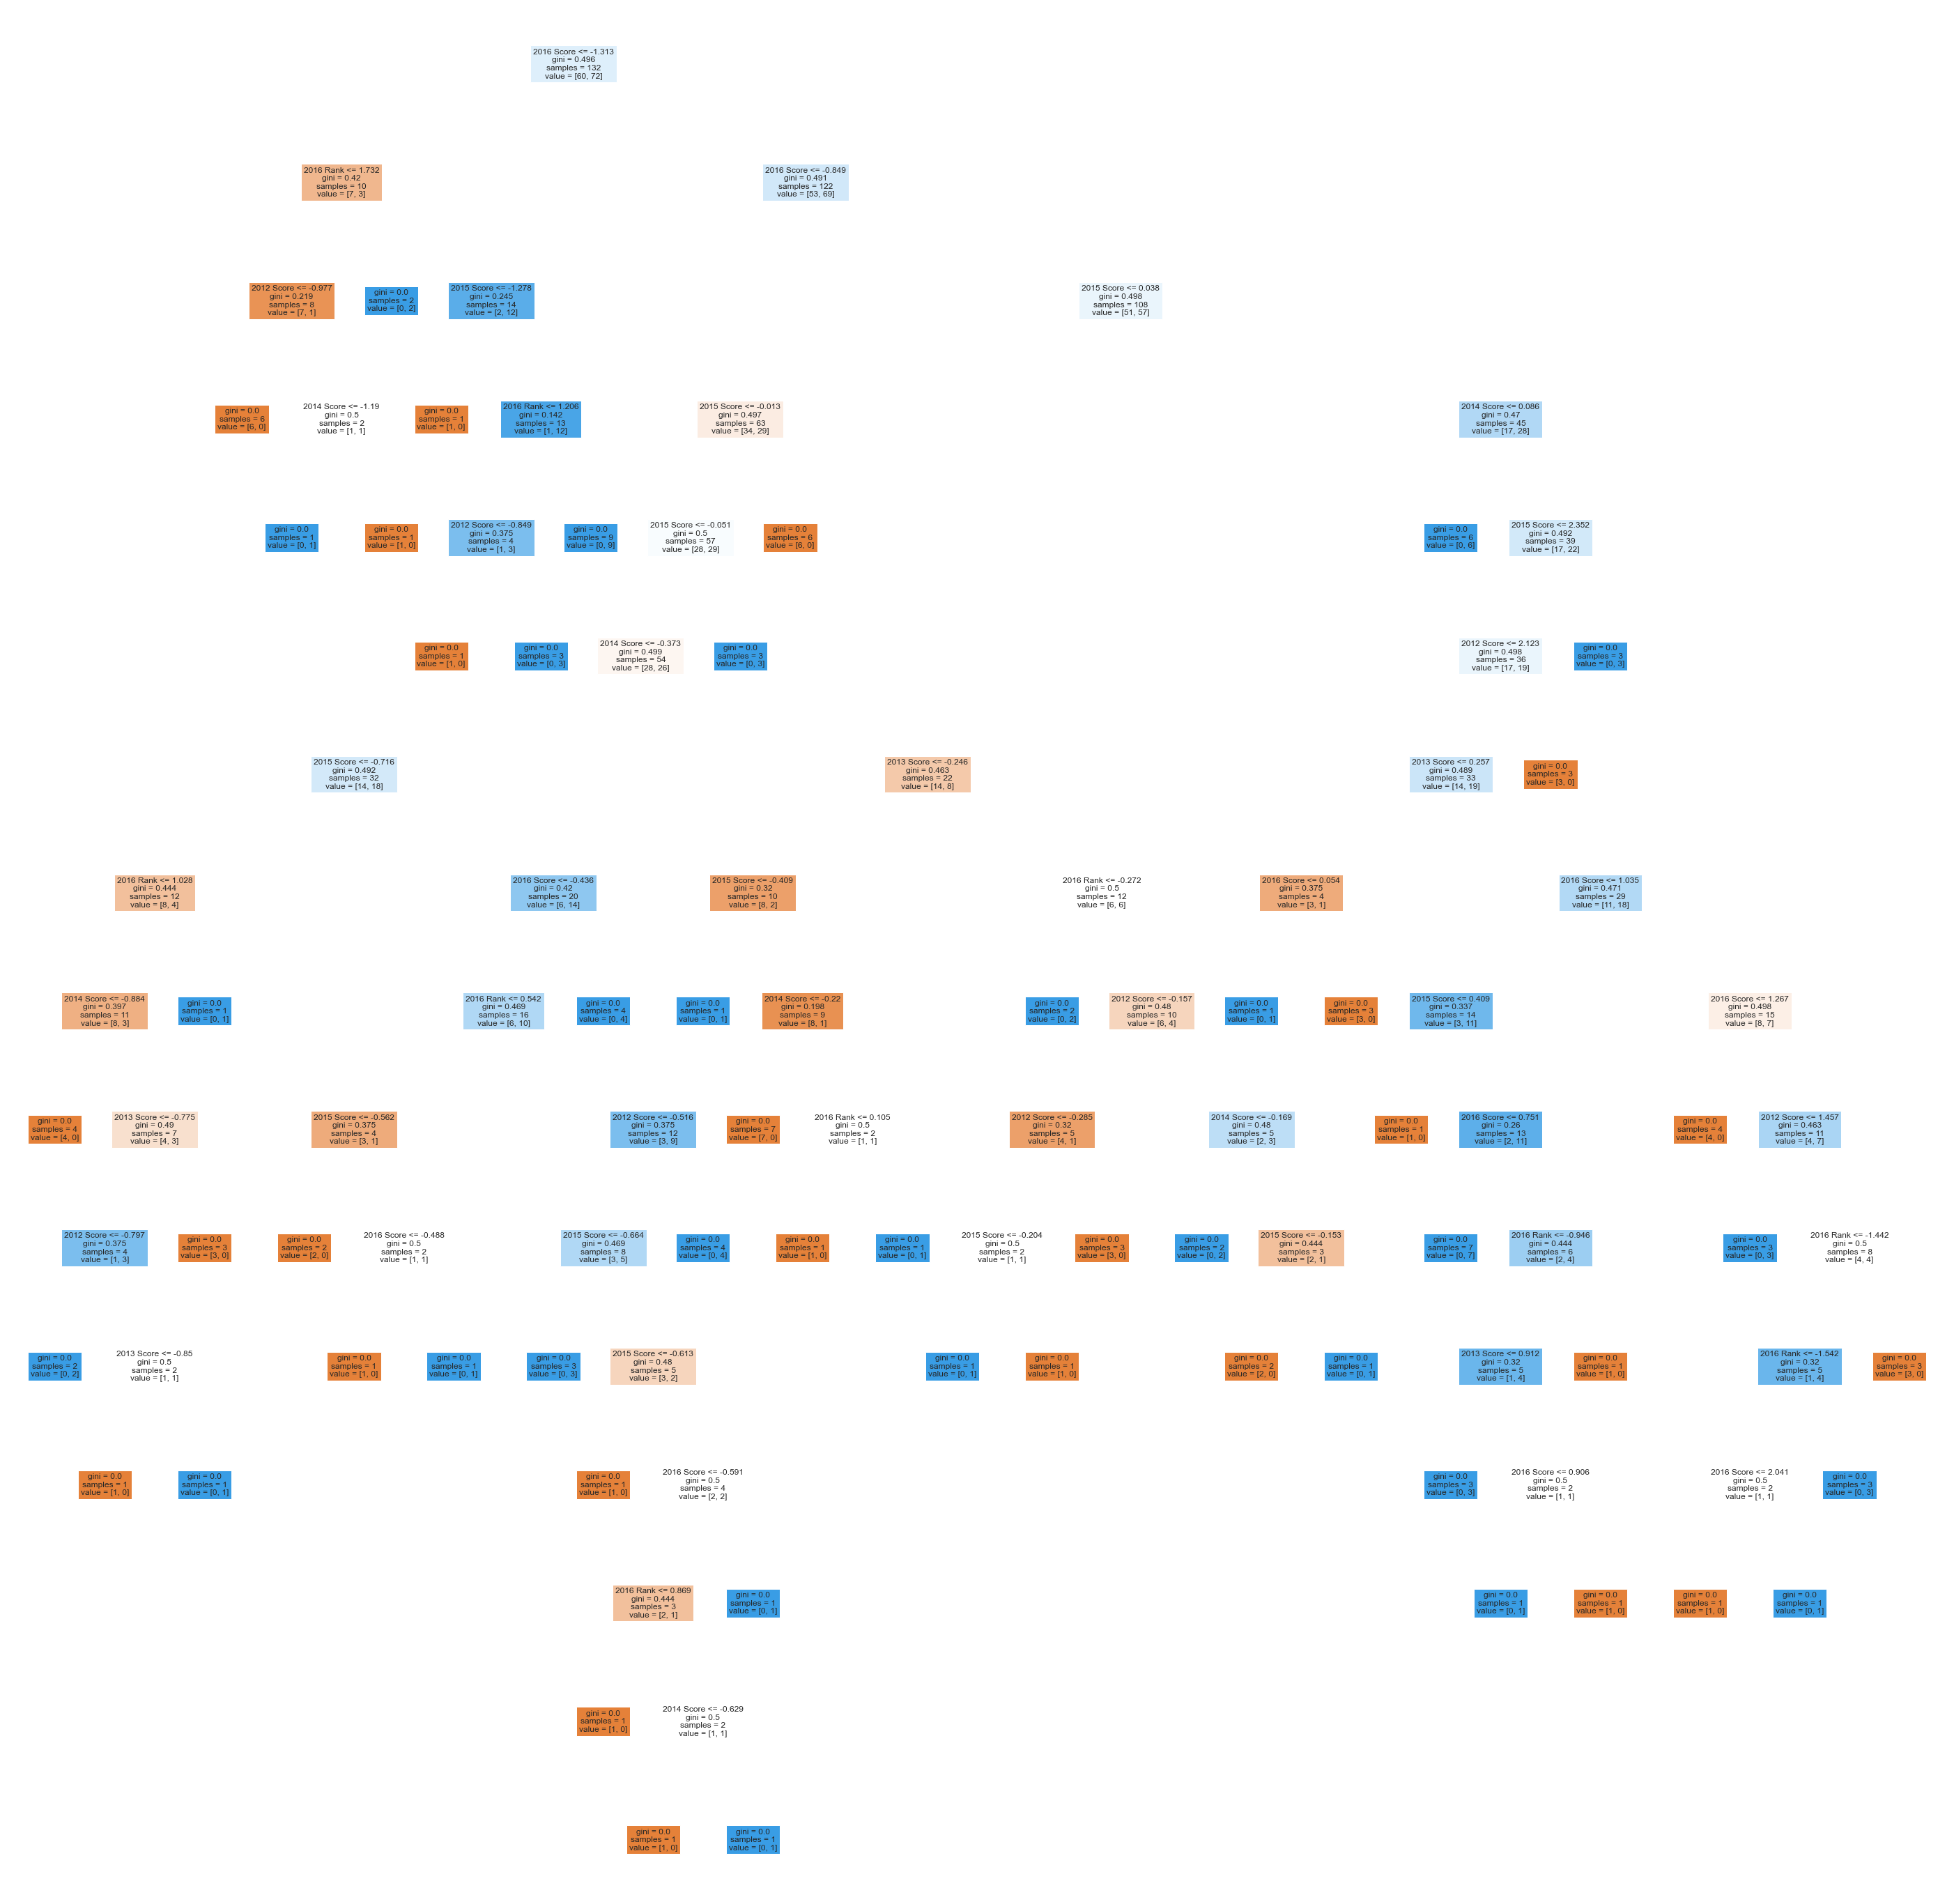

In [27]:
fig, ax = plt.subplots(figsize=(50, 50))
plot_tree(DTС, ax=ax, filled='true', fontsize=12, feature_names=data.columns)
plt.savefig('DTС', dpi=100)

Сравнивая качество моделей, можно сделать вывод, что метод опорных векторов (SVM) показал лучшие практические результаты.